## News Category Prediction

### Importing important library

In [36]:
try:
    import json
    import os
    
    import pandas as  pd
    import numpy as np
    import spacy
    
    import seaborn as sns
    import string

    from tqdm import tqdm
    from textblob import TextBlob
    
    from nltk.corpus import stopwords
    import nltk
    from nltk.stem import WordNetLemmatizer
    from nltk import word_tokenize
    import re
    
    
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import LabelEncoder
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.feature_extraction.text import TfidfTransformer
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.pipeline import Pipeline
    from sklearn.metrics import accuracy_score, confusion_matrix
    
    
    import swifter
    
    tqdm.pandas()
except Exception as e:
    print("Error : {} ".format(e))
    


In [ ]:
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

## Reading data

In [37]:
df = pd.read_json("News_Category_Dataset_v2.json", lines=True)

In [38]:
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


## Checking Null values

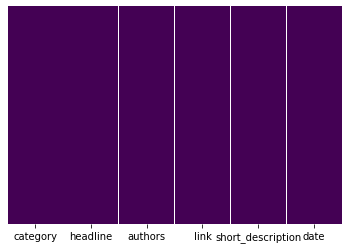

In [39]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

## Checking unique Category in Target column

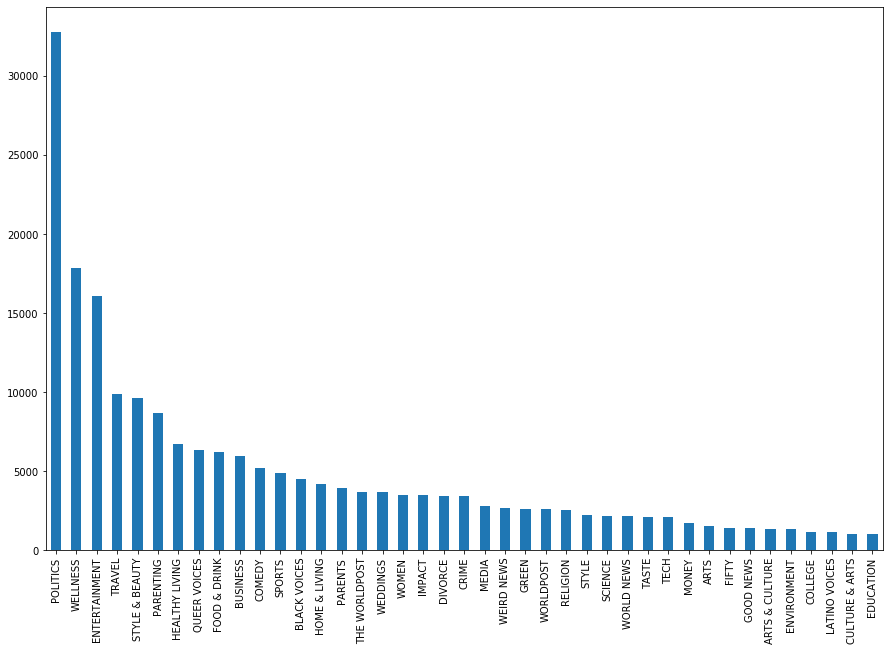

In [40]:
df['category'].value_counts().plot( kind='bar', figsize=(15,10))

In [41]:
df.columns

Index(['category', 'headline', 'authors', 'link', 'short_description', 'date'], dtype='object')

In [42]:
df.describe()

,category,headline,authors,link,short_description,date
count,200853,200853,200853,200853,200853,200853
unique,41,199344,27993,200812,178353,2309
top,POLITICS,Sunday Roundup,,https://www.huffingtonpost.comhttp://stylelike...,,2013-04-24 00:00:00
freq,32739,90,36620,2,19712,100
first,NaN,NaN,NaN,NaN,NaN,2012-01-28 00:00:00
last,NaN,NaN,NaN,NaN,NaN,2018-05-26 00:00:00


In [43]:
df.isna().sum()

category             0
headline             0
authors              0
link                 0
short_description    0
date                 0
dtype: int64

In [44]:
df['category'].unique()

array(['CRIME', 'ENTERTAINMENT', 'WORLD NEWS', 'IMPACT', 'POLITICS',
       'WEIRD NEWS', 'BLACK VOICES', 'WOMEN', 'COMEDY', 'QUEER VOICES',
       'SPORTS', 'BUSINESS', 'TRAVEL', 'MEDIA', 'TECH', 'RELIGION',
       'SCIENCE', 'LATINO VOICES', 'EDUCATION', 'COLLEGE', 'PARENTS',
       'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE', 'HEALTHY LIVING',
       'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST', 'FIFTY', 'ARTS',
       'WELLNESS', 'PARENTING', 'HOME & LIVING', 'STYLE & BEAUTY',
       'DIVORCE', 'WEDDINGS', 'FOOD & DRINK', 'MONEY', 'ENVIRONMENT',
       'CULTURE & ARTS'], dtype=object)

## Data Preprocessing

In [45]:
stop_words_ = set(stopwords.words('english'))
wn = WordNetLemmatizer()
my_sw = ['make', 'amp',  'news','new' ,'time', 'u','s', 'photos',  'get', 'say']

def black_txt(token):
    return  token not in stop_words_ and token not in list(string.punctuation)  and len(token)>2 and token not in my_sw
  
def clean_txt(text):
    clean_text = []
    clean_text2 = []
    text = re.sub("'", "",text)
    text=re.sub("(\\d|\\W)+"," ",text)    
    clean_text = [ wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
    clean_text2 = [word for word in clean_text if black_txt(word)]
    return " ".join(clean_text2)

In [46]:
def subj_txt(text):
    return  TextBlob(text).sentiment[1]

def polarity_txt(text):
    return TextBlob(text).sentiment[0]

def len_text(text):
    if len(text.split())>0:
         return len(set(clean_txt(text).split()))/ len(text.split())
    else:
         return 0

## Applying Function

In [47]:
df['text'] = df['headline']  +  " " + df['short_description']

df['text'] = df['text'].swifter.apply(clean_txt)
df['polarity'] = df['text'].swifter.apply(polarity_txt)
df['subjectivity'] = df['text'].swifter.apply(subj_txt)
df['len'] = df['text'].swifter.apply(lambda x: len(x))

Pandas Apply:   0%|          | 0/200853 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/200853 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/200853 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/200853 [00:00<?, ?it/s]

## Extracting Dependent and Independent Variable

In [48]:
X = df[['text', 'polarity', 'subjectivity','len']]
y =df['category']

## Converting Target column categorical into numerical using Label Encoder

In [49]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

## Splitting Data

In [50]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
v = dict(zip(list(y), df['category'].to_list()))

## Building Pipeline

In [51]:
text_clf = Pipeline([
        ('vect', CountVectorizer(analyzer="word", stop_words="english")),
        ('tfidf', TfidfTransformer(use_idf=True)),
        ('clf', MultinomialNB(alpha=.01))]
            )

## Training Model

In [52]:
text_clf.fit(x_train['text'].to_list(), list(y_train))

Pipeline(steps=[('vect', CountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB(alpha=0.01))])

In [53]:
X_TEST = x_test['text'].to_list()
Y_TEST = list(y_test)

## Prediction

In [54]:
predicted = text_clf.predict(X_TEST)

In [55]:
c = 0

for doc, category in zip(X_TEST, predicted):
    
    if c == 10:break
    
    print("-"*55)
    print(doc)
    print(v[category])
    print("-"*55)

    c = c + 1 

-------------------------------------------------------
beer goggle warn dangers adjust perception video let face facts today cinco mayo kentucky derby either one things give young people license
WELLNESS
-------------------------------------------------------
-------------------------------------------------------
twitter absolutely lose evil avocado macaroni cheese recipe please keep avocado macaroni cheese
FOOD & DRINK
-------------------------------------------------------
-------------------------------------------------------
herbal supplement commonly use type complementary medicine nearly percent american adults take herbs supplement vitamins minerals
WELLNESS
-------------------------------------------------------
-------------------------------------------------------
blind dog little help best pomeranian friend fluffy duo
GOOD NEWS
-------------------------------------------------------
-------------------------------------------------------
california ban pet shop sales non

## Checking Accuracy

In [58]:
np.mean(predicted == Y_TEST)

0.5528615170147619

In [57]:
accuracy_score(Y_TEST, predicted)

0.5528615170147619

In [ ]:
docs_new = ['Ten Months After George Floyd’s Death, Minneapolis Residents Are at War Over Policing']

In [ ]:
predicted = text_clf.predict(docs_new)

In [ ]:
v[predicted[0]]

## Saving Model

In [ ]:
import pickle
with open('model.pkl','wb') as f:
    pickle.dump(text_clf,f)

In [ ]:
# load
with open('model.pkl', 'rb') as f:
    clf2 = pickle.load(f)

In [ ]:
docs_new = ['Ten Months After George Floyd’s Death, Minneapolis Residents Are at War Over Policing']
predicted = clf2.predict(docs_new)

In [ ]:
v[predicted[0]]